Load dependencies, data and start pre-processing:

In [46]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def rep_converter(rep_value):
    if rep_value > 0:
        return ((math.log10(rep_value) - 9) * 9) + 25
    else:
        return 0

posts_df = pd.read_csv('./data/01_04-07_04.csv')
posts_df.drop(['created', 'permlink'], axis=1, inplace=True)
posts_df.author_reputation = posts_df.author_reputation.apply(rep_converter)
print(posts_df.shape)
posts_df.head()

(130329, 5)


,author,total_payout_value,children,net_votes,author_reputation
0,scottshots,11.98,31,408,54.969166
1,krguidedog,4.52,0,19,63.468104
2,ksg,0.71,1,3,46.867117
3,dannaxkana,0.15,1,5,49.226084
4,smilegenie,4.35,0,4,49.169891


Aggregate posts list into authors lists with computed meadian values:  

In [72]:
author_stats_median = posts_df.groupby('author', as_index=False).agg('median')
author_stats_median.head()

,author,total_payout_value,children,net_votes,author_reputation
0,a-0-0-0-0-0-a,0.100,2.5,3.0,27.410446
1,a-0-0-0-a,0.170,7.0,13.0,45.524626
2,a-0-labon,0.035,1.0,26.0,42.478402
3,a-0-mita,0.020,1.0,25.0,43.834942
4,a-7,0.160,2.0,8.0,56.211649


Run elbow rule analysis to estimate optimal clusters number:

Text(0.5,1,'Elbow curve')

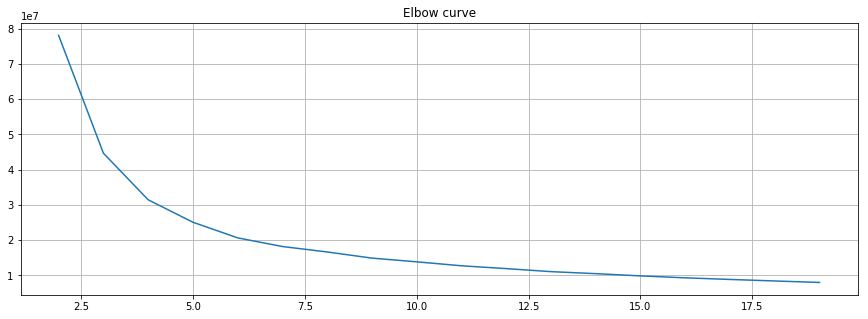

In [73]:
authors_stats_median_cleaned = author_stats_median.drop(['author'], axis=1)
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(authors_stats_median_cleaned)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Run KMeans clustering with optimal clusters number (6 in our case), then assign cluster number and appropriate color to each author:

In [78]:
kmeans_model = KMeans(n_clusters=6, 
                    max_iter=100, 
                    tol=0.0001, 
                    precompute_distances='auto', 
                    n_jobs=1, 
                    algorithm='auto').fit(authors_stats_median_cleaned)
labels=kmeans_model.labels_.tolist()
author_stats_ = author_stats_median
author_stats_['cluster'] = labels

def assign_color(x):
    x['color'] = colors[x['cluster']]
    return x
colors = ['#D9674F', '#68B6AF', '#938677', '#EBE5C7', '#E7E4CD', '#A380B5']
author_stats_ = author_stats_.apply(assign_color, axis=1)

First attempt to visualize data:

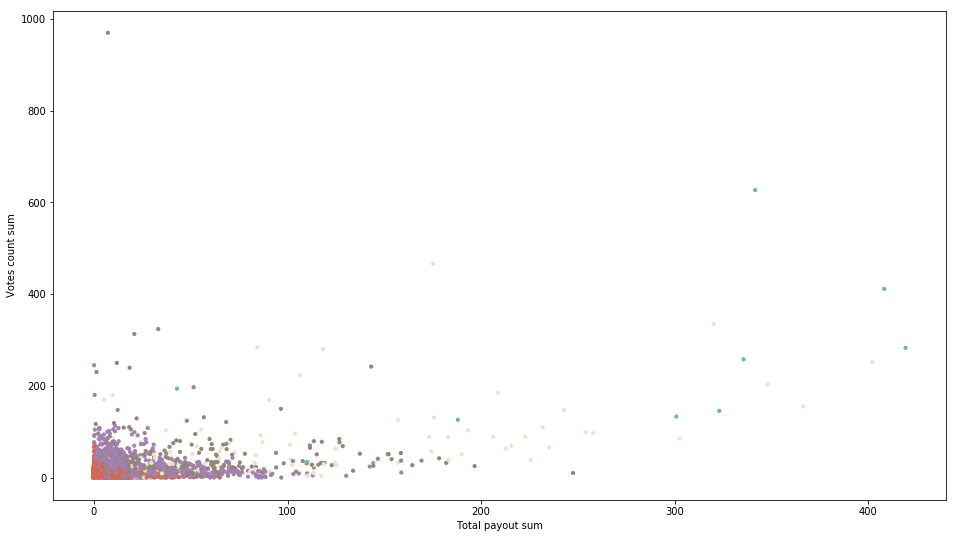

In [81]:
without_outliers = author_stats_

plt.scatter(without_outliers.total_payout_value, without_outliers.children, color=without_outliers.color, s=10)
plt.xlabel('Total payout sum')
plt.ylabel('Votes count sum')
plt.show()

3D visualisation of clustering results:

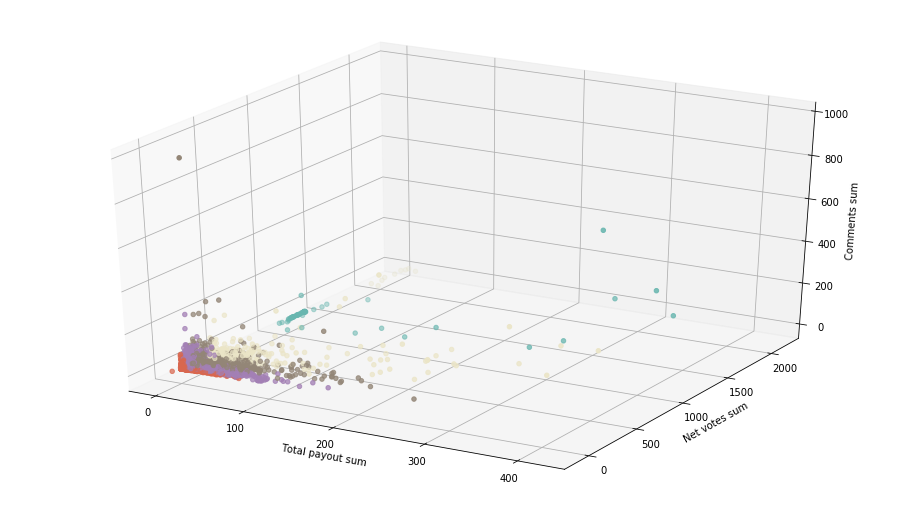

In [83]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(without_outliers.total_payout_value, 
           without_outliers.net_votes, 
           without_outliers.children, 
           zdir='z', s=20, c=without_outliers['color'], depthshade=True)
ax.set_xlabel('Total payout sum')
ax.set_ylabel('Net votes sum')
ax.set_zlabel('Comments sum')
plt.show()

Median values of each cluster:

In [85]:
author_clusters = without_outliers.groupby('cluster', as_index=False).agg('median')
author_clusters

,cluster,total_payout_value,children,net_votes,author_reputation
0,0,0.2000,2.0,9.0,42.269560
1,1,1.8850,1.0,1137.0,36.449818
2,2,3.7700,6.0,113.0,50.064963
3,3,17.2300,10.0,307.0,54.911364
4,4,11.6900,3.0,2054.5,60.635048
5,5,1.7975,5.5,46.0,52.069943


Decompose a 4-dimensional matrix into 2-dimensional space through PCA:

In [87]:
from sklearn.decomposition import PCA
data_ = without_outliers.drop(['cluster', 'color', 'author'], axis=1)
model = PCA(n_components=2)
model.fit(data_)
result = model.transform(data_)

Visualise result 2d-space to see clearly visible cluster boundaries: 

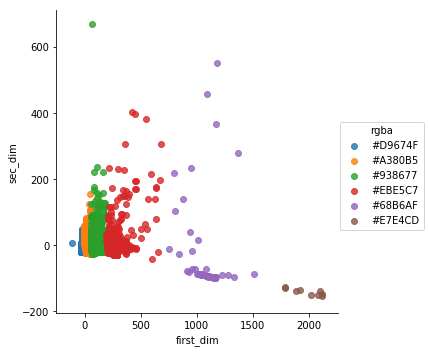

In [112]:
import seaborn as sns

result_ = pd.DataFrame(result, columns=['first_dim', 'sec_dim'])
result_['rgba'] = without_outliers.color

sns.lmplot(x='first_dim', y='sec_dim', hue='rgba', 
           fit_reg=False, data=result_)